In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pulp

if 'project2' in os.getcwd():
    os.chdir('..')
    
from data.parse import *
from project2.uta.uta import UTA
from project2.uta.uta_plotting import plot_marginal_value_functions, get_ranking
from project2.kendall import *

***
# UTA

In [3]:
UTAresults = UTA()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ignacy/miniconda3/envs/putenv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/607f3b181c2e4e539eb06c2e8ef3133b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/607f3b181c2e4e539eb06c2e8ef3133b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 143 COLUMNS
At line 796 RHS
At line 935 BOUNDS
At line 1002 ENDATA
Problem MODEL has 138 rows, 198 columns and 552 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 89 (-49) rows, 95 (-103) columns and 306 (-246) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 1.0954017e-06 ( 0.00010954017%) - largest zero change 1.0803902e-06
0  Obj 1.9701789e-07 Primal inf 2.02677 (30)
31  Obj 3.8953863e-06 Primal inf 0.142687 (13)
65  Obj 0.018004527
Optimal - objective value 0.018
After Postsolve, objective 0.018, infeasibil

### UTA 2.1

In [4]:
pairwise_comparisons_UTA

,name1,name2,relation
0,The Godfather,Forrest Gump,better
1,Catwoman,The Prestige,worse
2,Inception,Pulp Fiction,better
3,Batman & Robin,The Dark Knight,worse
4,Whiplash,The Dark Knight,worse
5,Birdemic: Shock and Terror,The Dark Knight,worse
6,Birdemic: Shock and Terror,Inception,worse
7,Jack and Jill,The Dark Knight,worse
8,Jack and Jill,The Godfather,worse
9,Inception,Catwoman,better


In [5]:
for i, hist in enumerate(UTAresults['inconsistent_solution_history']):
    print(f'Iteration {i+1}:')
    print('Inconsistency removed:', hist['true'])
    print('Consistent:', hist['false'])

Iteration 1:
Inconsistency removed: ['Slack_Catwoman_The_Dark_Knight_better', 'Slack_The_Dark_Knight_The_Prestige_better', 'Slack_The_Room_Battlefield_Earth_better']
Consistent: ['Slack_Batman_&_Robin_The_Dark_Knight_worse', 'Slack_Battlefield_Earth_Fifty_Shades_of_Grey_worse', 'Slack_Birdemic:_Shock_and_Terror_Inception_worse', 'Slack_Birdemic:_Shock_and_Terror_The_Dark_Knight_worse', 'Slack_Catwoman_Jack_and_Jill_worse', 'Slack_Catwoman_The_Prestige_worse', 'Slack_Dune_2_The_Godfather_better', 'Slack_Fifty_Shades_of_Grey_Forrest_Gump_worse', 'Slack_Forrest_Gump_The_Godfather_worse', 'Slack_Gladiator_Forrest_Gump_better', 'Slack_Inception_Catwoman_better', 'Slack_Inception_Gladiator_better', 'Slack_Inception_Pulp_Fiction_better', 'Slack_Jack_and_Jill_The_Dark_Knight_worse', 'Slack_Jack_and_Jill_The_Godfather_worse', 'Slack_Se7en_The_Godfather_better', 'Slack_Shutter_Island_The_Godfather_better', 'Slack_The_Departed_Inception_worse', 'Slack_The_Godfather_Forrest_Gump_better', 'Slack_Th

`Discuss the results: [TODO]`

### UTA 2.2

In [6]:
# Inconsistency that was removed:
UTAresults['final_inconsistency_removed']['true']

['Slack_Catwoman_The_Dark_Knight_better',
 'Slack_The_Dark_Knight_The_Prestige_better',
 'Slack_The_Room_Battlefield_Earth_better']

In [7]:
problem: pulp.LpProblem = UTAresults['final_pulp_problem']

In [8]:
# List all variables and their values
for v in problem.variables():
    print(v.name, '=', v.varValue)

Acting1 = 0.0
Acting10 = 0.035
Acting2 = 0.0
Acting3 = 0.0
Acting4 = 0.0
Acting5 = 0.0
Acting6 = 0.0
Acting7 = 0.0
Acting8 = 0.0349
Acting9 = 0.0349
Batman_&_Robin = 0.1798
Battlefield_Earth = 0.2147
Birdemic:_Shock_and_Terror = 0.2147
Catwoman = 0.1797
Critics_Score1 = 0.0
Critics_Score10 = 0.5
Critics_Score2 = 0.0
Critics_Score3 = 0.0
Critics_Score4 = 0.0
Critics_Score5 = 0.0
Critics_Score6 = 0.0
Critics_Score7 = 0.0
Critics_Score8 = 0.0
Critics_Score9 = 0.0
Dune_2 = 0.2852
Fifty_Shades_of_Grey = 0.2148
Fight_Club = 0.2502
Foodfight! = 0.2147
Forrest_Gump = 0.2149
Gigli = 0.2147
Gladiator = 0.2501
Goodfellas = 0.25
Inception = 0.2502
Jack_and_Jill = 0.2147
Music1 = 0.0
Music2 = 0.0
Music3 = 0.0001
Music4 = 0.18
Music5 = 0.18
Oscars_Won0 = 0.0
Oscars_Won1 = 0.0
Oscars_Won10 = 0.0
Oscars_Won11 = 0.0
Oscars_Won12 = 0.0
Oscars_Won13 = 0.0
Oscars_Won14 = 0.0
Oscars_Won15 = 0.0
Oscars_Won16 = 0.0
Oscars_Won17 = 0.0
Oscars_Won18 = 0.0
Oscars_Won19 = 0.0
Oscars_Won2 = 0.0
Oscars_Won20 = 0.0


In [9]:
# Print all constraints
print('Constraints:')
for c in problem.constraints:
    print(problem.constraints[c])

Constraints:
Acting1 - Acting2 <= 0
Acting2 - Acting3 <= 0
Acting3 - Acting4 <= 0
Acting4 - Acting5 <= 0
Acting5 - Acting6 <= 0
Acting6 - Acting7 <= 0
Acting7 - Acting8 <= 0
Acting8 - Acting9 <= 0
-Acting10 + Acting9 <= 0
Plot1 - Plot2 <= 0
Plot2 - Plot3 <= 0
Plot3 - Plot4 <= 0
Plot4 - Plot5 <= 0
Pictures1 - Pictures2 <= 0
Pictures2 - Pictures3 <= 0
Pictures3 - Pictures4 <= 0
Pictures4 - Pictures5 <= 0
Pictures5 - Pictures6 <= 0
Pictures6 - Pictures7 <= 0
Pictures7 - Pictures8 <= 0
Pictures8 - Pictures9 <= 0
-Pictures10 + Pictures9 <= 0
Music1 - Music2 <= 0
Music2 - Music3 <= 0
Music3 - Music4 <= 0
Music4 - Music5 <= 0
Sentiment0 - Sentiment1 <= 0
Critics_Score1 - Critics_Score2 <= 0
Critics_Score2 - Critics_Score3 <= 0
Critics_Score3 - Critics_Score4 <= 0
Critics_Score4 - Critics_Score5 <= 0
Critics_Score5 - Critics_Score6 <= 0
Critics_Score6 - Critics_Score7 <= 0
Critics_Score7 - Critics_Score8 <= 0
Critics_Score8 - Critics_Score9 <= 0
-Critics_Score10 + Critics_Score9 <= 0
Oscars_Wo

In [10]:
# Print the equation
print('Objective function:')
print(problem.objective)

Objective function:
OverEstimationError_Batman_&_Robin(in_comp_Batman_&_Robin_The_Dark_Knight_3_) + OverEstimationError_Battlefield_Earth(in_comp_Battlefield_Earth_Fifty_Shades_of_Grey_22_) + OverEstimationError_Birdemic:_Shock_and_Terror(in_comp_Birdemic:_Shock_and_Terror_Inception_6_) + OverEstimationError_Birdemic:_Shock_and_Terror(in_comp_Birdemic:_Shock_and_Terror_The_Dark_Knight_5_) + OverEstimationError_Catwoman(in_comp_Catwoman_Jack_and_Jill_21_) + OverEstimationError_Catwoman(in_comp_Catwoman_The_Prestige_1_) + OverEstimationError_Catwoman(in_comp_Inception_Catwoman_9_) + OverEstimationError_Dune_2(in_comp_Dune_2_The_Godfather_14_) + OverEstimationError_Fifty_Shades_of_Grey(in_comp_Battlefield_Earth_Fifty_Shades_of_Grey_22_) + OverEstimationError_Fifty_Shades_of_Grey(in_comp_Fifty_Shades_of_Grey_Forrest_Gump_15_) + OverEstimationError_Forrest_Gump(in_comp_Fifty_Shades_of_Grey_Forrest_Gump_15_) + OverEstimationError_Forrest_Gump(in_comp_Forrest_Gump_The_Godfather_13_) + OverEst

In [11]:
# 2.2 Final Objective value 
UTAresults['final_objective_value']

0.0

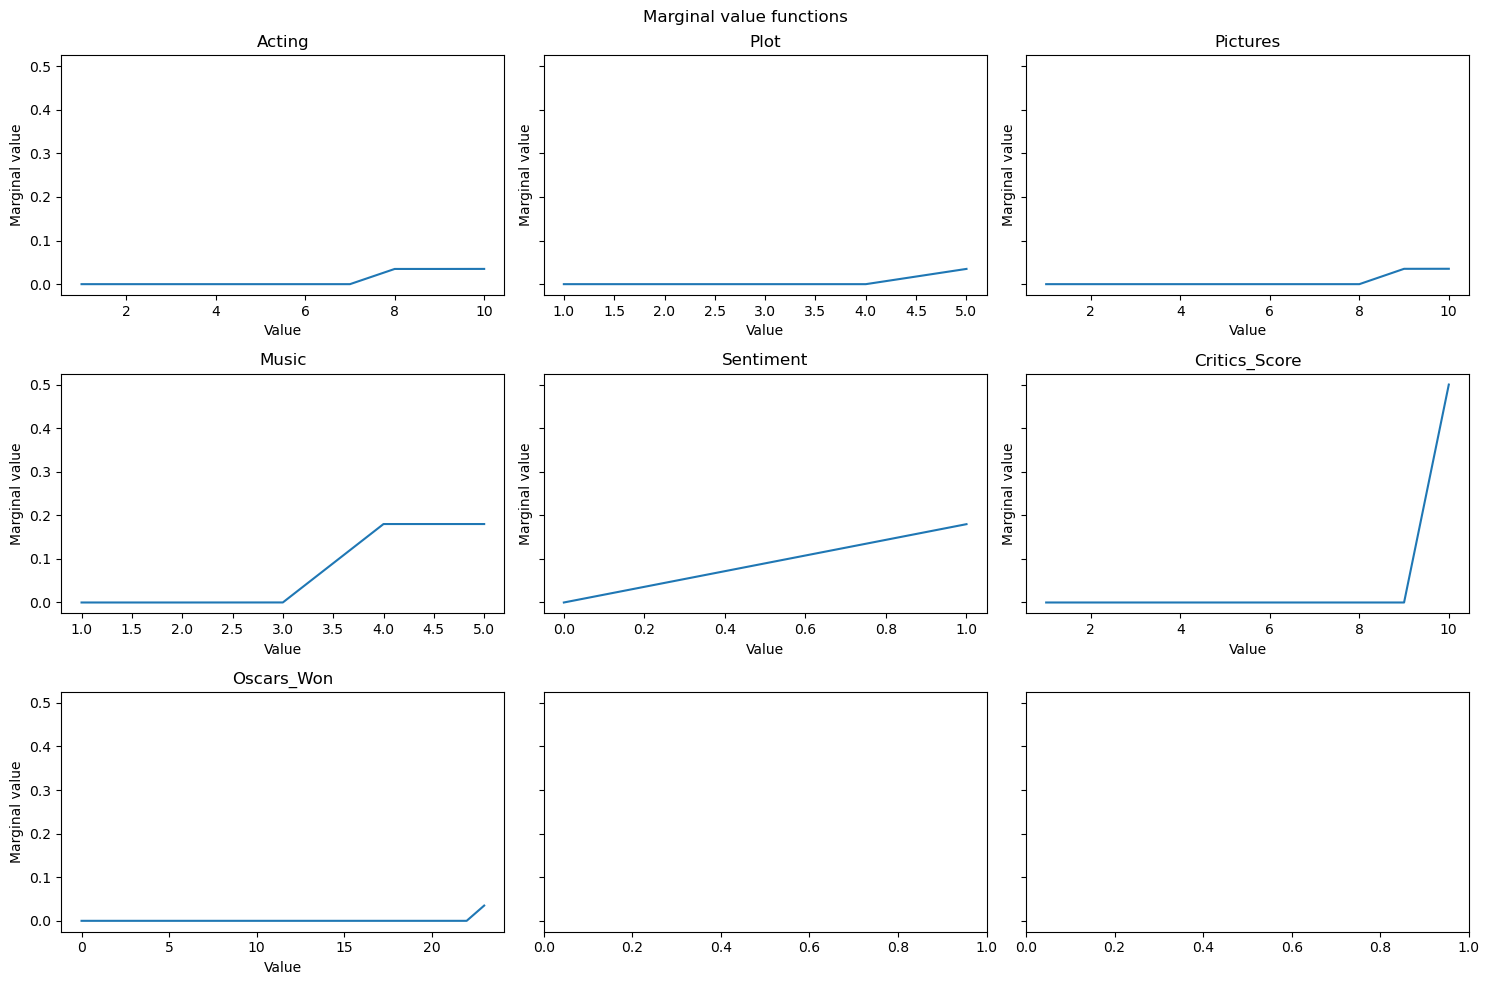

In [12]:
plot_marginal_value_functions(UTAresults, criteria, data)

In [28]:
uta_ranking = get_ranking(UTAresults, data)
uta_ranking

[('Shutter_Island', 0.3201),
 ('The_Lord_of_the_Rings:_The_Return_of_the_King', 0.2852),
 ('Dune_2', 0.2852),
 ('The_Prestige', 0.2852),
 ('Se7en', 0.285),
 ('Inception', 0.2502),
 ('Fight_Club', 0.2502),
 ('The_Dark_Knight', 0.2501),
 ('Gladiator', 0.2501),
 ('The_Godfather', 0.25),
 ("Schindler's_List", 0.25),
 ('Whiplash', 0.25),
 ('The_Godfather_Part_II', 0.25),
 ('The_Silence_of_the_Lambs', 0.25),
 ('Goodfellas', 0.25),
 ('The_Shawshank_Redemption', 0.2499),
 ('Pulp_Fiction', 0.2499),
 ('The_Green_Mile', 0.2499),
 ('The_Departed', 0.2499),
 ('Forrest_Gump', 0.2149),
 ('The_Matrix', 0.2149),
 ('Fifty_Shades_of_Grey', 0.2148),
 ('Transformers:_Revenge_of_the_Fallen', 0.2148),
 ('Gigli', 0.2147),
 ('The_Room', 0.2147),
 ('Jack_and_Jill', 0.2147),
 ('Birdemic:_Shock_and_Terror', 0.2147),
 ('Battlefield_Earth', 0.2147),
 ('Superbabies:_Baby_Geniuses_2', 0.2147),
 ('Foodfight!', 0.2147),
 ('Batman_&_Robin', 0.1798),
 ('Catwoman', 0.1797)]

In [29]:
calulate_kendall_matrix(uta_ranking, pretty_print=True)

,Catwoman,Batman_&_Robin,Gigli,The_Room,Jack_and_Jill,Birdemic:_Shock_and_Terror,Battlefield_Earth,Superbabies:_Baby_Geniuses_2,Foodfight!,Fifty_Shades_of_Grey,...,Goodfellas,The_Dark_Knight,Gladiator,Inception,Fight_Club,Se7en,The_Lord_of_the_Rings:_The_Return_of_the_King,Dune_2,The_Prestige,Shutter_Island
Catwoman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Batman_&_Robin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gigli,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The_Room,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jack_and_Jill,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Birdemic:_Shock_and_Terror,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Battlefield_Earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Superbabies:_Baby_Geniuses_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Foodfight!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fifty_Shades_of_Grey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***
# AHP

***
# Comparison

In [30]:
promethee_ranking = [(x,y) for x, y in list(pd.read_csv('results/promethee/ranking_prom2_overall.csv').to_numpy())]
promethee_ranking

[('Birdemic: Shock and Terror', 18.43181818181818),
 ('The Room', 18.43181818181818),
 ('Foodfight!', 18.43181818181818),
 ('Superbabies: Baby Geniuses 2', 18.227272727272727),
 ('Gigli', 16.772727272727273),
 ('Catwoman', 16.31818181818182),
 ('Jack and Jill', 16.295454545454547),
 ('Battlefield Earth', 16.295454545454547),
 ('Transformers: Revenge of the Fallen', 13.931818181818183),
 ('Fifty Shades of Grey', 13.931818181818183),
 ('Batman & Robin', 12.863636363636363),
 ('Shutter Island', -3.772727272727273),
 ('Se7en', -3.772727272727273),
 ('Goodfellas', -4.340909090909092),
 ('Pulp Fiction', -4.340909090909092),
 ('Fight Club', -4.613636363636363),
 ('Dune 2', -4.977272727272728),
 ('The Dark Knight', -5.5227272727272725),
 ('The Prestige', -5.863636363636363),
 ('Whiplash', -8.431818181818183),
 ('The Godfather', -9.045454545454549),
 ('The Departed', -9.90909090909091),
 ('The Green Mile', -9.90909090909091),
 ('The Matrix', -10.295454545454543),
 ('Forrest Gump', -10.318181818

In [31]:
compute_kendalls_tau(uta_ranking, promethee_ranking)

0.9495967741935484